## Los datos
- Grupo
- Sexo
- Edad
- Modo_Llegada
- Lesión
- Queja_Principal
- Estado_Mental
- Dolor
- Dolor_NRS
- SBP
- DBP
- HR
- RR
- BT
- Saturación
- KTAS_Enfermera
- Diagnóstico_Urgencias
- Disposición
- KTAS_Experto
- Grupo_Error
- Duración_Estancia_Min
- Duración_KTAS_Min
- Error_Triaje


In [213]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

## 1. Carga de los datos

In [214]:
datos = pd.read_csv("./data/Regresión_train_data.csv")

In [215]:
datos.shape

(1000, 23)

In [216]:
datos.dtypes

Grupo                         int64
Sexo                          int64
Edad                          int64
Modo_Llegada                  int64
Lesion                        int64
Queja_Principal              object
Estado_Mental                 int64
Dolor                         int64
dolor_NRS                    object
SBP                         float64
DBP                         float64
HR                          float64
RR                          float64
BT                          float64
Saturacion                  float64
KTAS_enfermera                int64
Diagnostico_En_Urgencias     object
Disposicion                   int64
KTAS_experto                  int64
Grupo_De_Error                int64
Duracion_Estancia_Min         int64
Duracion_KTAS_Min            object
Error_Triaje                  int64
dtype: object

In [217]:
datos.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
993,1,1,74,3,1,abd pain,1,1,3,189.0,...,36.3,NaN,4,Symptomatic gallbladder stone without obstruction,2,4,0,561,"4,82",0
205,1,1,59,3,1,LLQ pain,1,1,3,142.0,...,36.8,NaN,3,Constipation,1,3,0,76,"7,00",0
256,2,2,86,4,1,ant. chest pain,1,1,3,110.0,...,36.3,90.0,2,Myocardial infarction with non-ST elevation,2,2,0,11177,"4,00",0
140,1,1,83,2,1,dyspnea,1,0,#BOÞ!,164.0,...,36.7,NaN,3,Dyspnea,2,3,0,286,"5,82",0
95,2,1,53,3,1,epigastric pain,1,1,3,120.0,...,36.2,98.0,3,Infectious or septic colitis,1,4,4,8067,"5,00",1


## 2. Entendimiento de los datos

Variables numericas candidatas a utilizar

In [218]:
candidatas = ["Sexo","Edad","Modo_Llegada","Lesion","Estado_Mental","Dolor","KTAS_enfermera","Disposicion","KTAS_experto","Duracion_KTAS_Min"]

In [219]:
datos.describe()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,Saturacion,KTAS_enfermera,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Error_Triaje
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,983.000000,979.000000,988.000000,985.000000,989.000000,444.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.450000,1.514000,53.892000,2.811000,1.2000,1.103000,0.562000,133.485249,79.566905,84.400810,19.450761,36.562993,97.047297,3.328000,1.610000,3.260000,0.569000,12792.480000,0.253000
std,0.497743,0.500054,19.826483,0.796186,0.4002,0.431946,0.496389,27.156136,15.174593,16.297428,2.069882,0.519699,4.761112,0.862067,1.161572,0.865534,1.587375,87721.151446,0.630387
min,1.000000,1.000000,16.000000,1.000000,1.0000,1.000000,0.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,36.000000,2.000000,1.0000,1.000000,0.000000,114.000000,70.000000,73.000000,18.000000,36.200000,97.000000,3.000000,1.000000,3.000000,0.000000,132.750000,0.000000
50%,1.000000,2.000000,56.000000,3.000000,1.0000,1.000000,1.000000,130.000000,80.000000,82.000000,20.000000,36.500000,98.000000,3.000000,1.000000,3.000000,0.000000,270.500000,0.000000
75%,2.000000,2.000000,70.250000,3.000000,1.0000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,99.000000,4.000000,2.000000,4.000000,0.000000,620.000000,0.000000
max,2.000000,2.000000,94.000000,7.000000,2.0000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,39.800000,100.000000,5.000000,7.000000,5.000000,9.000000,709510.000000,2.000000


In [220]:
datos["Sexo"].value_counts()


Sexo
2    514
1    486
Name: count, dtype: int64

In [221]:
datos["dolor_NRS"].value_counts()

dolor_NRS
#BOÞ!    440
3        209
4        111
5        109
6         59
2         31
7         27
8          8
10         3
1          2
9          1
Name: count, dtype: int64

In [222]:
datos["Error_Triaje"].value_counts()

Error_Triaje
0    851
2    104
1     45
Name: count, dtype: int64

In [223]:
datos["Grupo_De_Error"].value_counts().sort_index()


Grupo_De_Error
0    851
1     16
2     39
3      6
4     50
5     11
6      6
7      7
8      9
9      5
Name: count, dtype: int64

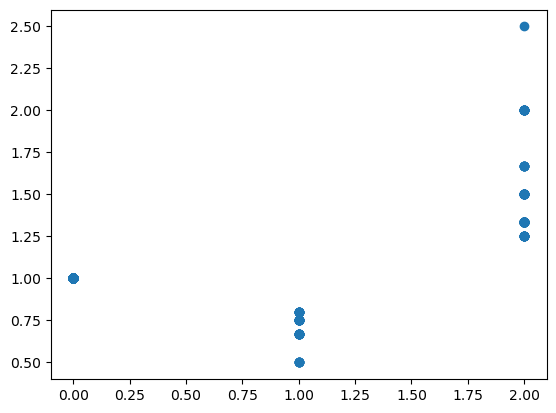

In [224]:
datos[["KTAS_enfermera","KTAS_experto","Error_Triaje"]]
a = datos[datos["KTAS_enfermera"]!=datos["KTAS_experto"]][["KTAS_enfermera","KTAS_experto","Error_Triaje"]]
a[a["Error_Triaje"]==1]
plt.scatter(datos["Error_Triaje"], datos["KTAS_enfermera"]/datos["KTAS_experto"])


Análisis de completitud

In [225]:
datos.isnull().sum() / datos.shape[0]

Grupo                       0.000
Sexo                        0.000
Edad                        0.000
Modo_Llegada                0.000
Lesion                      0.000
Queja_Principal             0.000
Estado_Mental               0.000
Dolor                       0.000
dolor_NRS                   0.000
SBP                         0.017
DBP                         0.021
HR                          0.012
RR                          0.015
BT                          0.011
Saturacion                  0.556
KTAS_enfermera              0.000
Diagnostico_En_Urgencias    0.001
Disposicion                 0.000
KTAS_experto                0.000
Grupo_De_Error              0.000
Duracion_Estancia_Min       0.000
Duracion_KTAS_Min           0.000
Error_Triaje                0.000
dtype: float64

### 2.1. Búsqueda de relaciones con la variable objetivo

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

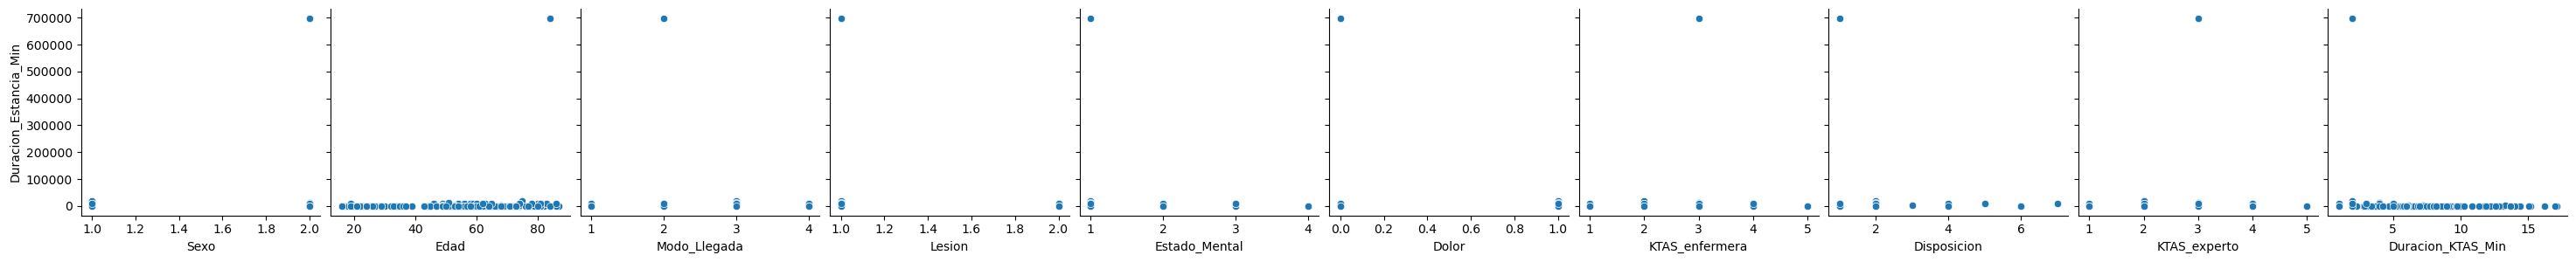

In [226]:
datos["Duracion_KTAS_Min"] = datos["Duracion_KTAS_Min"].str.replace(',', '.').astype('float64')
sns.pairplot(datos.sample(frac=0.2), height=3, y_vars="Duracion_Estancia_Min", x_vars=candidatas, kind="scatter")

### 2.2. Búsqueda de relaciones entre las variables de entrada

**Importante:** La regresión lineal asume que sus variables de entrada no se encuentran altamente correlacionados.

<Axes: >

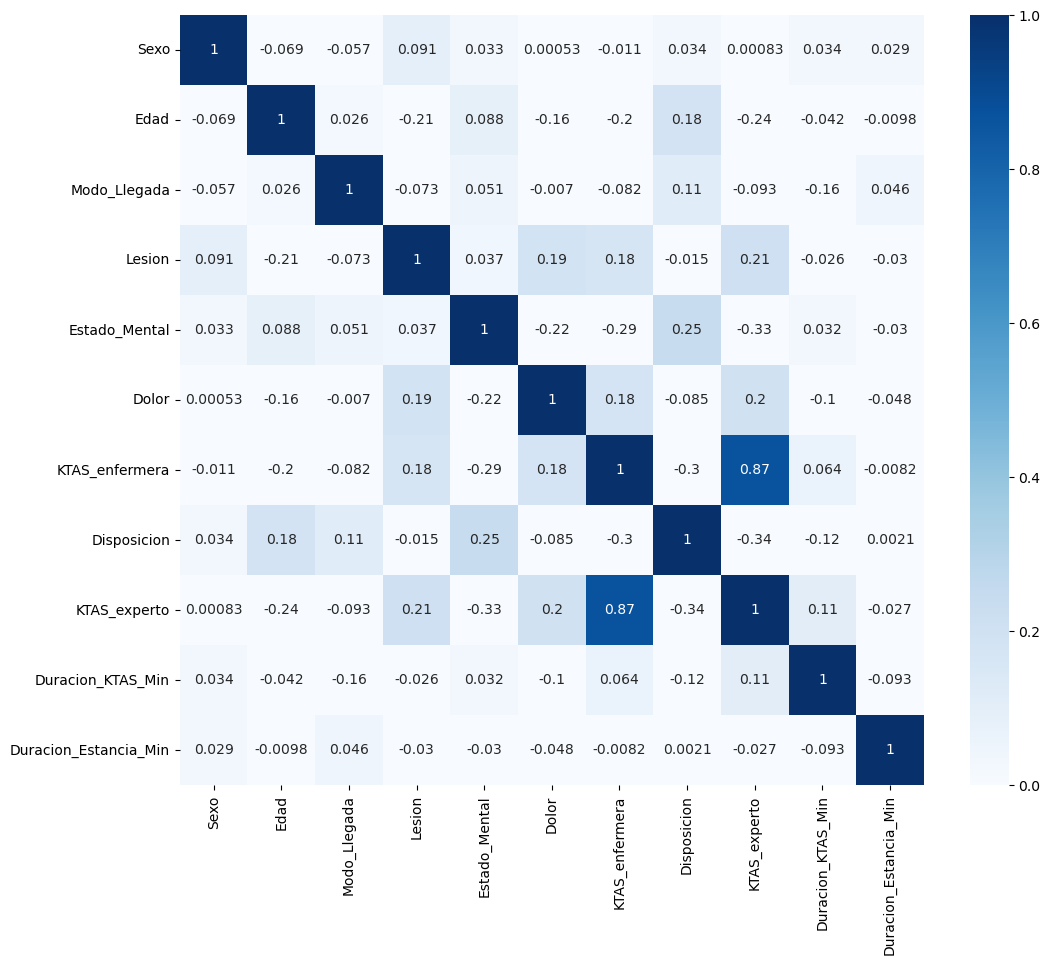

In [227]:
plt.figure(figsize=(12, 10))
sns.heatmap(datos[candidatas+['Duracion_Estancia_Min']].corr(), cmap="Blues", vmin=0, vmax=1, annot = True)

## 3. Preparación de datos

### 3.1. Relacionado con la calidad de los datos

In [228]:
# Se eliminan los registros totalmente duplicados
datos = datos.dropna(subset=["Duracion_Estancia_Min"]+candidatas)

In [229]:
datos.shape
total_rows = datos.shape[0]
total_rows

1000

In [230]:
datos[["Duracion_Estancia_Min"]+candidatas].isnull().sum() / datos.shape[0]

Duracion_Estancia_Min    0.0
Sexo                     0.0
Edad                     0.0
Modo_Llegada             0.0
Lesion                   0.0
Estado_Mental            0.0
Dolor                    0.0
KTAS_enfermera           0.0
Disposicion              0.0
KTAS_experto             0.0
Duracion_KTAS_Min        0.0
dtype: float64

In [231]:
datos[datos[["Duracion_Estancia_Min"]+candidatas] == '#BOÞ!'][["Duracion_Estancia_Min"]+candidatas].count()/ datos.shape[0]

Duracion_Estancia_Min    0.0
Sexo                     0.0
Edad                     0.0
Modo_Llegada             0.0
Lesion                   0.0
Estado_Mental            0.0
Dolor                    0.0
KTAS_enfermera           0.0
Disposicion              0.0
KTAS_experto             0.0
Duracion_KTAS_Min        0.0
dtype: float64

In [232]:
datos.loc[datos.duplicated(subset=candidatas, keep=False)].head(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
20,1,2,78,3,1,dizziness,1,0,#BOÞ!,132.0,...,36.8,NaN,3,Dizziness,1,3,0,129,5.38,0
55,2,2,40,3,1,"Leg pain, NOS",1,1,3,110.0,...,36.4,NaN,5,Complex regional pain syndrome type II,1,5,0,60,2.00,0
71,2,1,41,3,2,Open Wound,1,1,3,130.0,...,36.6,98.0,4,"Open wound of head, part unspecified",1,4,0,125,4.00,0
87,1,1,81,2,1,dizziness,1,0,#BOÞ!,154.0,...,35.7,NaN,3,Dizziness,1,3,0,332,3.88,0
99,1,1,22,2,2,headache,1,1,5,106.0,...,36.5,NaN,3,Multiple abrasion,1,3,0,148,6.87,0


In [233]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas, keep=False)].shape[0]
duplicated_rows

72

In [234]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 7.2000%


In [235]:
datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].tail(4)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
996,1,1,27,3,1,Suicidal Attempt,1,0,#BOÞ!,110.0,...,36.2,NaN,3,Suicide tendency,2,3,0,442,7.42,0
997,1,2,54,2,1,"pain, chest",1,1,6,159.0,...,36.6,NaN,2,Gastroesophageal reflux disease,1,2,0,214,4.95,0
998,1,1,19,3,1,eye discomfort,1,0,#BOÞ!,132.0,...,36.5,NaN,4,Corneal erosion,1,4,0,50,3.45,0
999,1,2,29,3,1,"pain, abdominal",1,1,6,137.0,...,37.6,NaN,3,Allergic reaction,1,3,0,116,5.97,0


In [236]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].shape[0]
duplicated_rows

67

In [237]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 6.7000%


In [238]:
datos.drop_duplicates(subset=candidatas, inplace=True)
datos.drop_duplicates(subset=candidatas+["Duracion_Estancia_Min"], inplace=True)

In [239]:
datos.shape

(963, 23)